In [1]:
import hydra
from glob import  glob
import numpy as np
import matplotlib.pyplot as plt
from omegaconf import OmegaConf

from proteoscope.data import ProteoscopeDM
from proteoscope.modules import AutoencoderLM, ProteoscopeLM


test = 'proteoscope' # proteoscope autoencoder

# BASE_DIR = f"/home/ec2-user/outputs/proteoscope/2023-08-22/07-18-31" # Best proteoscope - ESM-full
# BASE_DIR = f"/home/ec2-user/outputs/proteoscope/2023-08-22/07-24-27" # Best proteoscope - ESM-mean
BASE_DIR = f"/home/ec2-user/outputs/proteoscope/2023-09-01/20-18-02" # Best proteoscope - ESM-full
# BASE_DIR = f"/home/ec2-user/outputs/autoencoder/2023-08-19/17-28-45" # Best autoencoder

protein_split = 'all_fov_' # '' or 'all_' or 'all_fov_
config_dir = BASE_DIR + "/.hydra"

with hydra.initialize_config_dir(config_dir=config_dir):
    config = hydra.compose(config_name="config", overrides=OmegaConf.load(config_dir + "/overrides.yaml"))

    chkpts = glob(BASE_DIR + "/checkpoints/*.ckpt")
    chkpts.sort()
    chkpt = chkpts[-1] #-1
    print('   Using ', chkpt)

    pdm = ProteoscopeDM(
        images_path=config.data.images_path,
        labels_path=config.data.labels_path,
        sequences_path=config.data.sequences_path,
        batch_size=config.trainer.batch_size,
        num_workers=config.trainer.num_workers,
        trim=config.data.trim,
        sequence_embedding=config.data.sequence_embedding,
        splits=config.splits,
    )
    pdm.setup()

    if test == 'autoencoder':
        alm = AutoencoderLM.load_from_checkpoint(
            chkpt,
            module_config=config.module,
            strict=False,
        )

        alm.vae.to('cuda')
        alm.eval()
    elif test == 'proteoscope':
        plm = ProteoscopeLM.load_from_checkpoint(
            chkpt,
            module_config=config.module,
            strict=False,
        )

        plm.eval()
        plm.cuda()
    else:
        raise ValueError(f"Unrecognized option {test}")

/tmp/ipykernel_18389/3253592141.py:21: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with hydra.initialize_config_dir(config_dir=config_dir):


   Using  /home/ec2-user/outputs/proteoscope/2023-09-01/20-18-02/checkpoints/last.ckpt


/home/ec2-user/proteoscope/proteoscope/data/datamodule.py:43: DtypeWarning: Columns (17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  self.labels = pd.read_csv(self.labels_path, index_col=0)
/opt/conda/envs/pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth


/opt/conda/envs/pytorch/lib/python3.9/site-packages/torchvision/ops/misc.py:120: UserWarning: Don't use ConvNormActivation directly, please use Conv2dNormActivation and Conv3dNormActivation instead.
  warnings.warn(


In [2]:
from proteoscope.modules import CytoselfLM


cytoself_checkpoint = '/home/ec2-user/outputs/cytoself/2023-09-02/05-17-26/checkpoints/last.ckpt'
cytoself_config = config.module.copy()
cytoself_config.model = config.module.model.cytoself.model
plm.cytoself = CytoselfLM.load_from_checkpoint(
    cytoself_checkpoint,
    module_config=cytoself_config,
    num_class=config.module.model.cytoself.num_class,
).model
plm.cytoself.to('cuda')
plm.cytoself.eval()

CytoselfFull(
  (encoders): ModuleList(
    (0): EfficientNet(
      (features): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Sequential(
          (0): MBConv(
            (block): Sequential(
              (0): ConvNormActivation(
                (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
                (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (2): SiLU(inplace=True)
              )
              (1): SqueezeExcitation(
                (avgpool): AdaptiveAvgPool2d(output_size=1)
                (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
                (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              

## Reconstruct val images

In [948]:
# dl = pdm.val_dataloader()
dl = pdm.custom_dataloader(split_images='val', split_protein='val', shuffle=42, downsample=10)

In [949]:
import torch
from tqdm import tqdm
import numpy as np
from piqa import SSIM, PSNR
from torchmetrics.image.fid import FrechetInceptionDistance

gs = 3.0
nis = 50

ssim = SSIM(n_channels=1).to('cuda')
psnr = PSNR().to('cuda')
fid_pro = FrechetInceptionDistance(normalize=True).to('cuda')
fid_nuc = FrechetInceptionDistance(normalize=True).to('cuda')

index = []
input_images = []
output_images = []
input_cytoself_embeds = []
output_cytoself_embeds = []
input_autoencoder_embeds = []
input_cytoself_logits = []
output_cytoself_logits = []
diffused_autoencoder_embeds = []

ssim_scores_pro = []
ssim_scores_nuc = []
psnr_scores_pro = []
psnr_scores_nuc = []

with torch.no_grad():
    for batch in tqdm(dl):
        batch['image'] = batch['image'].to('cuda')
        batch['sequence_embed'] = batch['sequence_embed'].to('cuda')
        batch['sequence_mask'] = batch['sequence_mask'].to('cuda')
        
        input_image = batch['image']
        input_cytoself_embed = plm.cytoself(input_image, 'vqvec2')
        _, input_cytoself_logit = plm.cytoself(input_image)

        if test == 'autoencoder':
            output_image, _, input_autoencoder_embed = alm(input_image, return_embed=True, sample_posterior=False)
            diffused_autoencoder_embed = torch.empty(0)
        elif test == 'proteoscope':
            diffused_autoencoder_embed = plm.sample(batch, guidance_scale=gs, cond_images=None, num_inference_steps=nis, seed=42)
            output_image = plm.autoencoder.decode(diffused_autoencoder_embed).sample
            input_autoencoder_embed = plm.autoencoder.encode(batch['image']).latent_dist.mean

        output_image = output_image.clip(0, 1)
        output_cytoself_embed = plm.cytoself(output_image, 'vqvec2')
        _, output_cytoself_logit = plm.cytoself(output_image)

        ssim_pro = ssim(input_image[:, 0].unsqueeze_(1), torch.clip(output_image[:, 0].unsqueeze_(1), 0, 1))
        ssim_nuc = ssim(input_image[:, 1].unsqueeze_(1), torch.clip(output_image[:, 1].unsqueeze_(1), 0, 1))

        psnr_pro = psnr(input_image[:, 0].unsqueeze_(1), torch.clip(output_image[:, 0].unsqueeze_(1), 0, 1))
        psnr_nuc = psnr(input_image[:, 1].unsqueeze_(1), torch.clip(output_image[:, 1].unsqueeze_(1), 0, 1))

        fid_pro.update(input_image[:, 0].unsqueeze_(1).tile(1, 3, 1, 1), real=True)
        fid_pro.update(torch.clip(output_image[:, 0].unsqueeze_(1), 0, 1).tile(1, 3, 1, 1), real=False)

        fid_nuc.update(input_image[:, 1].unsqueeze_(1).tile(1, 3, 1, 1), real=True)
        fid_nuc.update(torch.clip(output_image[:, 1].unsqueeze_(1), 0, 1).tile(1, 3, 1, 1), real=False)

        index.append(batch['index'].detach().cpu().numpy())
        ssim_scores_pro.append([ssim_pro.detach().cpu().numpy()])
        ssim_scores_nuc.append([ssim_nuc.detach().cpu().numpy()])
        psnr_scores_pro.append([psnr_pro.detach().cpu().numpy()])
        psnr_scores_nuc.append([psnr_nuc.detach().cpu().numpy()])
        input_images.append(input_image.detach().cpu().numpy())
        output_images.append(output_image.detach().cpu().numpy())
        input_cytoself_embeds.append(input_cytoself_embed.detach().cpu().numpy())
        output_cytoself_embeds.append(output_cytoself_embed.detach().cpu().numpy())
        input_autoencoder_embeds.append(input_autoencoder_embed.detach().cpu().numpy())
        input_cytoself_logits.append(input_cytoself_logit.detach().cpu().numpy())
        output_cytoself_logits.append(output_cytoself_logit.detach().cpu().numpy())
        diffused_autoencoder_embeds.append(diffused_autoencoder_embed.detach().cpu().numpy())

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  1%|▏         | 1/77 [00:08<10:54,  8.61s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  3%|▎         | 2/77 [00:15<09:42,  7.77s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  4%|▍         | 3/77 [00:22<09:14,  7.50s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  5%|▌         | 4/77 [00:30<08:57,  7.37s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  6%|▋         | 5/77 [00:37<08:45,  7.30s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  8%|▊         | 6/77 [00:44<08:35,  7.26s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  9%|▉         | 7/77 [00:51<08:26,  7.23s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 10%|█         | 8/77 [00:58<08:18,  7.22s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 12%|█▏        | 9/77 [01:06<08:10,  7.21s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 13%|█▎        | 10/77 [01:13<08:02,  7.20s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 14%|█▍        | 11/77 [01:20<07:54,  7.19s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 16%|█▌        | 12/77 [01:27<07:47,  7.19s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 17%|█▋        | 13/77 [01:34<07:40,  7.19s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 18%|█▊        | 14/77 [01:41<07:32,  7.19s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 19%|█▉        | 15/77 [01:49<07:25,  7.19s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 21%|██        | 16/77 [01:56<07:18,  7.19s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 22%|██▏       | 17/77 [02:03<07:11,  7.19s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 23%|██▎       | 18/77 [02:10<07:04,  7.19s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 25%|██▍       | 19/77 [02:17<06:56,  7.19s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 26%|██▌       | 20/77 [02:25<06:49,  7.19s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 27%|██▋       | 21/77 [02:32<06:42,  7.19s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 29%|██▊       | 22/77 [02:39<06:35,  7.19s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 30%|██▉       | 23/77 [02:46<06:28,  7.19s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 31%|███       | 24/77 [02:53<06:21,  7.19s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 32%|███▏      | 25/77 [03:01<06:14,  7.19s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 34%|███▍      | 26/77 [03:08<06:06,  7.19s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 35%|███▌      | 27/77 [03:15<05:59,  7.19s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 36%|███▋      | 28/77 [03:22<05:52,  7.19s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 38%|███▊      | 29/77 [03:29<05:45,  7.19s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 39%|███▉      | 30/77 [03:37<05:38,  7.19s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 40%|████      | 31/77 [03:44<05:30,  7.19s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 42%|████▏     | 32/77 [03:51<05:23,  7.20s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 43%|████▎     | 33/77 [03:58<05:16,  7.19s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 44%|████▍     | 34/77 [04:05<05:09,  7.19s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 45%|████▌     | 35/77 [04:13<05:02,  7.19s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 47%|████▋     | 36/77 [04:20<04:55,  7.20s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 48%|████▊     | 37/77 [04:27<04:47,  7.20s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 49%|████▉     | 38/77 [04:34<04:40,  7.20s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 51%|█████     | 39/77 [04:41<04:33,  7.20s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 52%|█████▏    | 40/77 [04:48<04:26,  7.20s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 53%|█████▎    | 41/77 [04:56<04:19,  7.20s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 55%|█████▍    | 42/77 [05:03<04:11,  7.19s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 56%|█████▌    | 43/77 [05:10<04:04,  7.19s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 57%|█████▋    | 44/77 [05:17<03:57,  7.19s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 58%|█████▊    | 45/77 [05:24<03:50,  7.19s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 60%|█████▉    | 46/77 [05:32<03:43,  7.19s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 61%|██████    | 47/77 [05:39<03:35,  7.19s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 62%|██████▏   | 48/77 [05:46<03:28,  7.20s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 64%|██████▎   | 49/77 [05:53<03:21,  7.19s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 65%|██████▍   | 50/77 [06:00<03:14,  7.19s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 66%|██████▌   | 51/77 [06:08<03:07,  7.19s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 68%|██████▊   | 52/77 [06:15<02:59,  7.19s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 69%|██████▉   | 53/77 [06:22<02:52,  7.19s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 70%|███████   | 54/77 [06:29<02:45,  7.19s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 71%|███████▏  | 55/77 [06:36<02:38,  7.20s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 73%|███████▎  | 56/77 [06:44<02:31,  7.19s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 74%|███████▍  | 57/77 [06:51<02:23,  7.19s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 75%|███████▌  | 58/77 [06:58<02:16,  7.19s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 77%|███████▋  | 59/77 [07:05<02:09,  7.20s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 78%|███████▊  | 60/77 [07:12<02:02,  7.19s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 79%|███████▉  | 61/77 [07:20<01:55,  7.19s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 81%|████████  | 62/77 [07:27<01:47,  7.19s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 82%|████████▏ | 63/77 [07:34<01:40,  7.19s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 83%|████████▎ | 64/77 [07:41<01:33,  7.19s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 84%|████████▍ | 65/77 [07:48<01:26,  7.19s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 86%|████████▌ | 66/77 [07:56<01:19,  7.20s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 87%|████████▋ | 67/77 [08:03<01:11,  7.20s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 88%|████████▊ | 68/77 [08:10<01:04,  7.19s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 90%|████████▉ | 69/77 [08:17<00:57,  7.20s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 91%|█████████ | 70/77 [08:24<00:50,  7.20s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 92%|█████████▏| 71/77 [08:32<00:43,  7.20s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 94%|█████████▎| 72/77 [08:39<00:36,  7.21s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 95%|█████████▍| 73/77 [08:46<00:28,  7.21s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 96%|█████████▌| 74/77 [08:53<00:21,  7.21s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 97%|█████████▋| 75/77 [09:00<00:14,  7.21s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 99%|█████████▊| 76/77 [09:08<00:07,  7.21s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 77/77 [09:13<00:00,  7.18s/it]


In [950]:
fid_pro_score = fid_pro.compute()
fid_nuc_score = fid_nuc.compute()

In [951]:
index = np.concatenate(index, axis=0)
ssim_scores_pro = np.concatenate(ssim_scores_pro, axis=0)
ssim_scores_nuc = np.concatenate(ssim_scores_nuc, axis=0)
psnr_scores_pro = np.concatenate(psnr_scores_pro, axis=0)
psnr_scores_nuc = np.concatenate(psnr_scores_nuc, axis=0)

In [952]:
input_images = np.concatenate(input_images, axis=0)
output_images = np.concatenate(output_images, axis=0)
input_cytoself_embeds = np.concatenate(input_cytoself_embeds, axis=0)
input_autoencoder_embeds = np.concatenate(input_autoencoder_embeds, axis=0)
diffused_autoencoder_embeds = np.concatenate(diffused_autoencoder_embeds, axis=0)

In [953]:
input_cytoself_logits = np.concatenate(input_cytoself_logits, axis=0)
output_cytoself_logits = np.concatenate(output_cytoself_logits, axis=0)
output_cytoself_embeds = np.concatenate(output_cytoself_embeds, axis=0)

In [954]:
# tmp_path = '/home/ec2-user/cytoself-data/tmp/full'

# np.save(f'{tmp_path}/index.npy', index)
# np.save(f'{tmp_path}/ssim_scores_pro.npy', ssim_scores_pro)
# np.save(f'{tmp_path}/ssim_scores_nuc.npy', ssim_scores_nuc)
# np.save(f'{tmp_path}/psnr_scores_pro.npy', psnr_scores_pro)
# np.save(f'{tmp_path}/psnr_scores_nuc.npy', psnr_scores_nuc)


# np.save(f'{tmp_path}/input_images.npy', input_images)
# np.save(f'{tmp_path}/output_images.npy', output_images)
# np.save(f'{tmp_path}/input_cytoself_embeds.npy', input_cytoself_embeds)
# np.save(f'{tmp_path}/input_autoencoder_embeds.npy', input_autoencoder_embeds)
# np.save(f'{tmp_path}/diffused_autoencoder_embeds.npy', diffused_autoencoder_embeds)

# np.save(f'{tmp_path}/input_cytoself_logits.npy', input_cytoself_logits)
# np.save(f'{tmp_path}/output_cytoself_logits.npy', output_cytoself_logits)
# np.save(f'{tmp_path}/output_cytoself_embeds.npy', output_cytoself_embeds)

In [955]:
# index = np.load(f'{tmp_path}/index.npy')
# ssim_scores_pro = np.load(f'{tmp_path}/ssim_scores_pro.npy')
# ssim_scores_nuc = np.load(f'{tmp_path}/ssim_scores_nuc.npy')
# psnr_scores_pro = np.load(f'{tmp_path}/psnr_scores_pro.npy')
# psnr_scores_nuc = np.load(f'{tmp_path}/psnr_scores_nuc.npy')


# input_images = np.load(f'{tmp_path}/input_images.npy')
# output_images = np.load(f'{tmp_path}/output_images.npy')
# input_cytoself_embeds = np.load(f'{tmp_path}/input_cytoself_embeds.npy')
# input_autoencoder_embeds = np.load(f'{tmp_path}/input_autoencoder_embeds.npy')
# diffused_autoencoder_embeds = np.load(f'{tmp_path}/diffused_autoencoder_embeds.npy')

# input_cytoself_logits = np.load(f'{tmp_path}/input_cytoself_logits.npy')
# output_cytoself_logits = np.load(f'{tmp_path}/output_cytoself_logits.npy')
# output_cytoself_embeds = np.load(f'{tmp_path}/output_cytoself_embeds.npy')

In [956]:
print(len(input_images))

1226


In [957]:
true_names = np.array(pdm.labels['name'])[index]
true_localizations = np.array(pdm.labels['localization'])[index]
true_labels = np.array(pdm.labels['label'])[index]

In [958]:
np.mean(input_autoencoder_embeds)

0.07063526

In [959]:
np.std(input_autoencoder_embeds)

2.9003131

In [960]:
print(input_autoencoder_embeds.max())
print(input_autoencoder_embeds.min())

9.320484
-8.787707


In [961]:
print(fid_pro_score)
print(fid_nuc_score)

tensor(34.0763, device='cuda:0')
tensor(21.7991, device='cuda:0')


In [962]:
print(ssim_scores_pro.mean())
print(ssim_scores_nuc.mean())

0.43798527
0.5239818


In [963]:
print(psnr_scores_pro.mean())
print(psnr_scores_nuc.mean())

20.486698
20.284466


In [964]:
input_cytoself_labels = input_cytoself_logits.argmax(axis=1)
output_cytoself_labels = output_cytoself_logits.argmax(axis=1)

Accuracy 0.49592169657422513


/tmp/ipykernel_18389/3474189015.py:13: RuntimeWarning: invalid value encountered in divide
  cm_norm = cm / cm.sum(axis=1)[:, None]


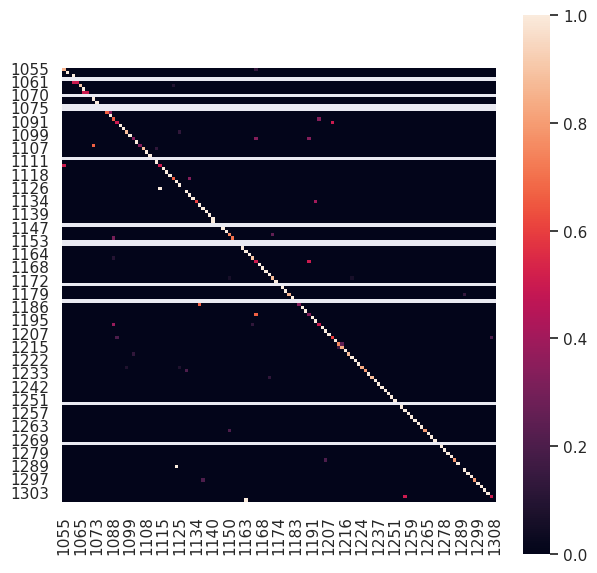

In [965]:
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

class_labels = np.unique(true_labels)
# class_labels = range(num_class)

acc = accuracy_score(true_labels, input_cytoself_labels)
print(f'Accuracy {acc}')

cm = confusion_matrix(true_labels, input_cytoself_labels, labels=class_labels)
cm_norm = cm / cm.sum(axis=1)[:, None]
cm_df = pd.DataFrame(cm_norm, index=class_labels, columns=class_labels)

plt.figure(figsize=(7, 7))
sns.heatmap(cm_df, square=True, annot=False, fmt=".2f");

Accuracy 0.01631321370309951


/tmp/ipykernel_18389/2910221747.py:5: RuntimeWarning: invalid value encountered in divide
  cm_norm = cm / cm.sum(axis=1)[:, None]


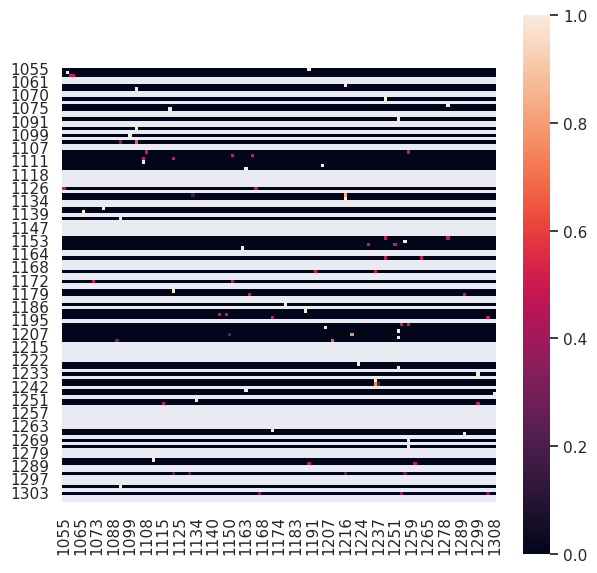

In [966]:
acc = accuracy_score(true_labels, output_cytoself_labels)
print(f'Accuracy {acc}')

cm = confusion_matrix(true_labels, output_cytoself_labels, labels=class_labels)
cm_norm = cm / cm.sum(axis=1)[:, None]
cm_df = pd.DataFrame(cm_norm, index=class_labels, columns=class_labels)

plt.figure(figsize=(7, 7))
sns.heatmap(cm_df, square=True, annot=False, fmt=".2f");

In [967]:
def top_k_accuracy(y_true, y_score, k=5):
    # Get the indices of the top k predicted classes for each sample
    top_k_preds = np.argsort(y_score, axis=1)[:, -k:]
    
    # Check if the true class is among the top k for each sample
    correct = np.any(top_k_preds == y_true[:, np.newaxis], axis=1)

    # Calculate the mean accuracy
    top_k_acc = np.mean(correct)
    
    return top_k_acc

In [968]:
input_classification_scores = [top_k_accuracy(true_labels, input_cytoself_logits, k=k) for k in range(1, 131)]

In [969]:
output_classification_scores = [top_k_accuracy(true_labels, output_cytoself_logits, k=k) for k in range(1, 131)]

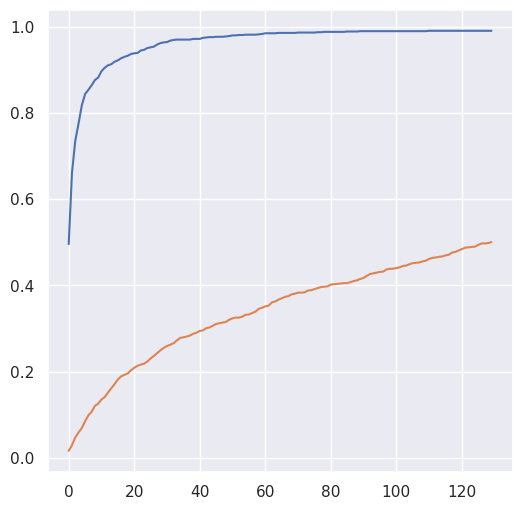

In [970]:
plt.figure(figsize=(6, 6));
plt.plot(input_classification_scores);
plt.plot(output_classification_scores);
# plt.plot(output_classification_scores_cache_3_0_25);
# plt.plot(output_classification_scores_cache_3_0_50);

In [971]:
print(input_classification_scores[13])
print(output_classification_scores[13])

print(input_classification_scores[-1])
print(output_classification_scores[-1])

0.9135399673735726
0.16150081566068517
0.9910277324632952
0.5008156606851549


In [972]:
import numpy as np
from collections import defaultdict
from scipy.special import softmax


def average_rows(arr, M):
    N = arr.shape[0]

    if M > N:
        raise ValueError("M must be less than or equal to N")

    # Create a random permutation of the rows
    permuted_indices = np.random.permutation(N)[: (N // M) * M]

    # Reshape the permuted indices to create groups of M rows
    groups_of_M = permuted_indices.reshape(N // M, M)

    # Average each group to produce N/M averages of M rows
    averaged_rows = [np.mean(arr[group], axis=0) for group in groups_of_M]

    return np.array(averaged_rows)


def average_logits_prediction(groups, labels, logits, M):
    logits_by_groups = defaultdict(list)
    label_by_groups = dict()
    for logit, group, label in zip(logits, groups, labels):
        logits_by_groups[group].append(logit)
        label_by_groups[group] = label

    n_pred = 0
    sum_pred = 0
    for key, logits in logits_by_groups.items():
        # logits = softmax(logits, axis=1)
        if M <= len(logits):
            averaged_predictions = average_rows(np.array(logits), M).argmax(axis=1)
            target = label_by_groups[key]
            sum_pred = sum_pred + (averaged_predictions == target).sum()
            n_pred = n_pred + len(averaged_predictions)

    return sum_pred / n_pred

In [1049]:
num_avg = 8
input_classification_scores_avg = [average_logits_prediction(true_labels, true_labels, input_cytoself_logits, M=k) for k in range(1, num_avg)]

In [1046]:
output_classification_scores_avg = [average_logits_prediction(true_labels, true_labels, output_cytoself_logits, M=k) for k in range(1, num_avg)]

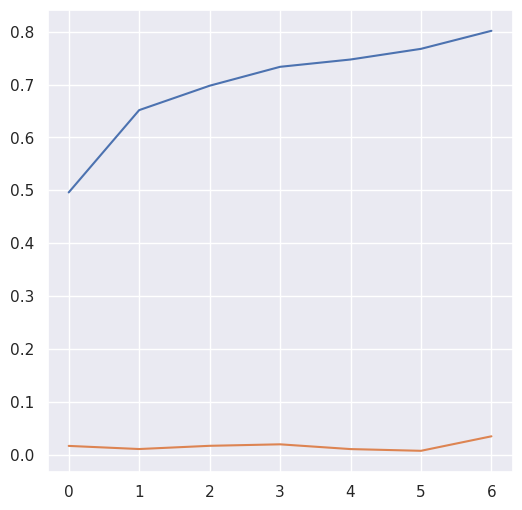

In [1047]:
plt.figure(figsize=(6, 6));
plt.plot(input_classification_scores_avg);
plt.plot(output_classification_scores_avg);

In [1048]:
print(input_classification_scores_avg[-1])
print(output_classification_scores_avg[-1])

0.8017241379310345
0.034482758620689655


In [1041]:
print((true_labels == input_cytoself_logits.argmax(axis=1)).mean())
print((true_labels == output_cytoself_logits.argmax(axis=1)).mean())

0.49592169657422513
0.01631321370309951


In [978]:
def cross_entropy_loss(y_true, logits, eps=1e-20):
    # Compute the softmax activation
    exp_logits = np.exp(logits - np.max(logits, axis=-1, keepdims=True))
    softmax_probs = exp_logits / np.sum(exp_logits, axis=-1, keepdims=True)

    # Gather the probabilities corresponding to the true labels
    true_probs = softmax_probs[np.arange(len(y_true)), y_true]

    # Compute the cross-entropy loss
    loss = -np.mean(np.log(true_probs + eps))

    return loss

In [979]:
print(cross_entropy_loss(true_labels, input_cytoself_logits))
print(cross_entropy_loss(true_labels, output_cytoself_logits))

2.186375
19.92676


In [980]:
print(np.mean((input_cytoself_embeds - output_cytoself_embeds)**2))

0.5924281


## Images

In [981]:
# FID ↓ IS ↑ PSNR ↑ SSIM ↑
# FCD, CS ....

In [982]:
from proteoscope.plotting import browse_reconstructions, merge_prot_nuc

In [983]:
# ['AKAP13' 'AMBRA1' 'ARFGAP2' 'ARHGAP35' 'CAMK1' 'CCT7' 'CD9' 'CEP135'
#  'CEPT1' 'CHM' 'DDX47' 'ECT2' 'FASN' 'FAU' 'GATAD1' 'HEATR3' 'IKBKB'
#  'LDHB' 'NCAPH' 'PACSIN2' 'PHLDB1' 'PPP2CA' 'RABGGTA' 'RANBP9' 'RPL13'
#  'SCAMP1' 'SLC23A2' 'SLC27A4' 'SLC4A2' 'SNF8' 'SNUPN' 'TUBA1B' 'USP1'
#  'VAPB' 'VRK2']

In [984]:
browse_reconstructions(input_images[:, 0], output_images[:, 0], true_names)

interactive(children=(Dropdown(description='name', options=('AGAP1', 'AKAP13', 'AKT2', 'AMBRA1', 'ANAPC11', 'A…

## Merged nuclei view

In [985]:
true_merged = merge_prot_nuc(input_images[:1000], percentiles=[0.1, 99.9])
predicted_merged = merge_prot_nuc(output_images[:1000], percentiles=[0.1, 99.9])
true_names_merged = true_names[:1000]

In [986]:
browse_reconstructions(true_merged, predicted_merged, true_names_merged)

interactive(children=(Dropdown(description='name', options=('AGAP1', 'AKAP13', 'AKT2', 'AMBRA1', 'ANAPC11', 'A…

## Visualize in cytoself umap

In [987]:
import zarr
from os.path import join
import numpy as np

datapath = "/home/ec2-user/cytoself-data/results"

In [988]:
zarr_path = join(datapath, f"cytoself_{protein_split}embeddings_vqvec2.zarr")

embeddings = np.asarray(zarr.open(zarr_path, mode='r'))
# localizations = np.load(join(datapath, "good_localizations_redo21.npy"))
# names = np.load(join(datapath, "good_names_redo21.npy"))
# complexes = np.load(join(datapath, "good_complexes_redo21.npy"))
# complexes_fig = np.load(join(datapath, "good_complexes_fig_redo21.npy"))


In [989]:
if protein_split == '':
    labels = pdm.labels[np.logical_and(pdm.labels['split_images_fov'] == 'val', pdm.labels['split_protein'] == 'train')]
elif protein_split == 'all_':
    labels = pdm.labels[pdm.labels['split_images'] == 'val']
else:
    labels = pdm.labels[pdm.labels['split_images_fov'] == 'val']

names = np.array(labels['name'])
localizations = np.array(labels['localization'])
complexes = np.array(labels['complex'])
complexes_fig = np.array(labels['complex_fig'])

shuffle = np.load(join(datapath, "cytoself_all_fov_embeddings_shuffle.npy"))
names = names[shuffle]
localizations = localizations[shuffle]
complexes = complexes[shuffle]
complexes_fig = complexes_fig[shuffle]

In [990]:
print(embeddings.max())
print(embeddings.min())

print(input_cytoself_embeds.max())
print(input_cytoself_embeds.min())

print(output_cytoself_embeds.max())
print(output_cytoself_embeds.min())

3.3475818634033203
-0.24840334057807922
3.3475816
-0.24840333
3.3475816
-0.24840333


In [991]:
from joblib import load

reducer = load(join(datapath, f'cytoself_{protein_split}umap_model.joblib'))

In [992]:
reduced_embedding = reducer.transform(embeddings.reshape(embeddings.shape[0], -1))

In [993]:
reduced_input_cytoself_embeds = reducer.transform(input_cytoself_embeds.reshape(input_cytoself_embeds.shape[0], -1))
reduced_output_cytoself_embeds = reducer.transform(output_cytoself_embeds.reshape(output_cytoself_embeds.shape[0], -1))

In [994]:
import seaborn as sns
import matplotlib.pyplot as plt

In [995]:
label_colors = {
    'other': [188, 188, 188],
    'mitochondria':  [135, 38, 35],
    'nucleoplasm':  [146, 210, 243],
    'ER':  [218, 56, 50],
    'cytoplasm':  [128, 189, 93],
    'vesicles':  [199, 175, 78],
    'nuclear_membrane':  [40, 63, 149],
    'nucleolus':  [93, 139, 198],
    'Golgi':  [216, 46, 138],
    'nuclear_domains':  [64, 144, 147],
}
for key, values in label_colors.items():
    label_colors[key] = np.array(values) / 255

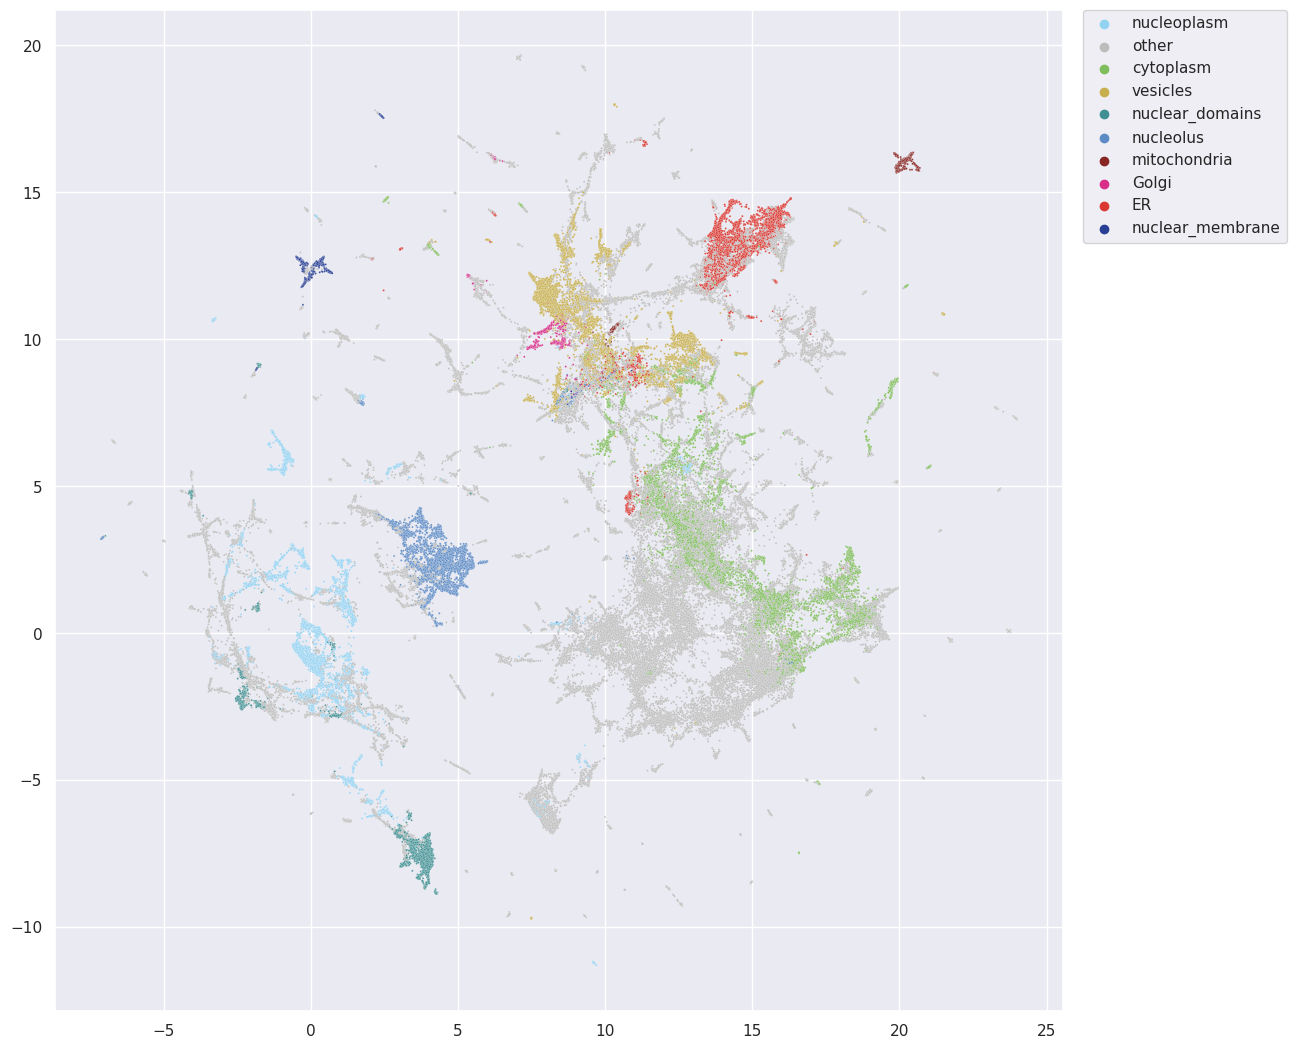

In [996]:
sns.set(rc={"figure.figsize":(13, 13)})
sns.scatterplot(x=reduced_embedding[:, 0], y=reduced_embedding[:, 1], hue=localizations, s=2, alpha=0.9, palette=label_colors)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0);

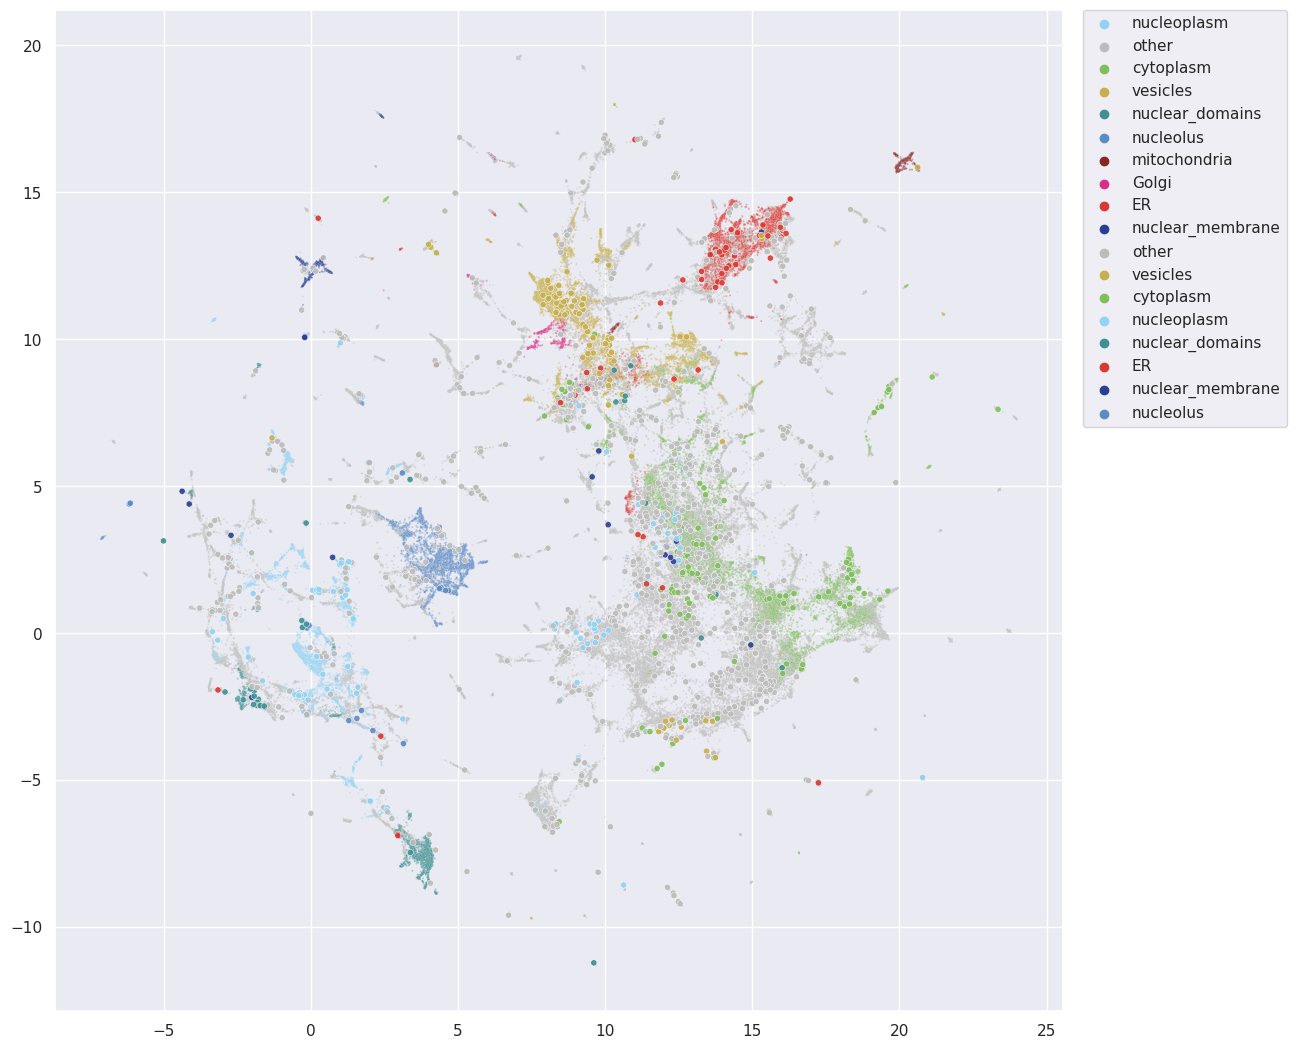

In [997]:
sns.set(rc={"figure.figsize":(13, 13)})
sns.scatterplot(x=reduced_embedding[:, 0], y=reduced_embedding[:, 1], hue=localizations, s=2, alpha=0.4, palette=label_colors)
sns.scatterplot(x=reduced_output_cytoself_embeds[:, 0], y=reduced_output_cytoself_embeds[:, 1], hue=true_localizations, s=20, alpha=0.9, palette=label_colors)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0);

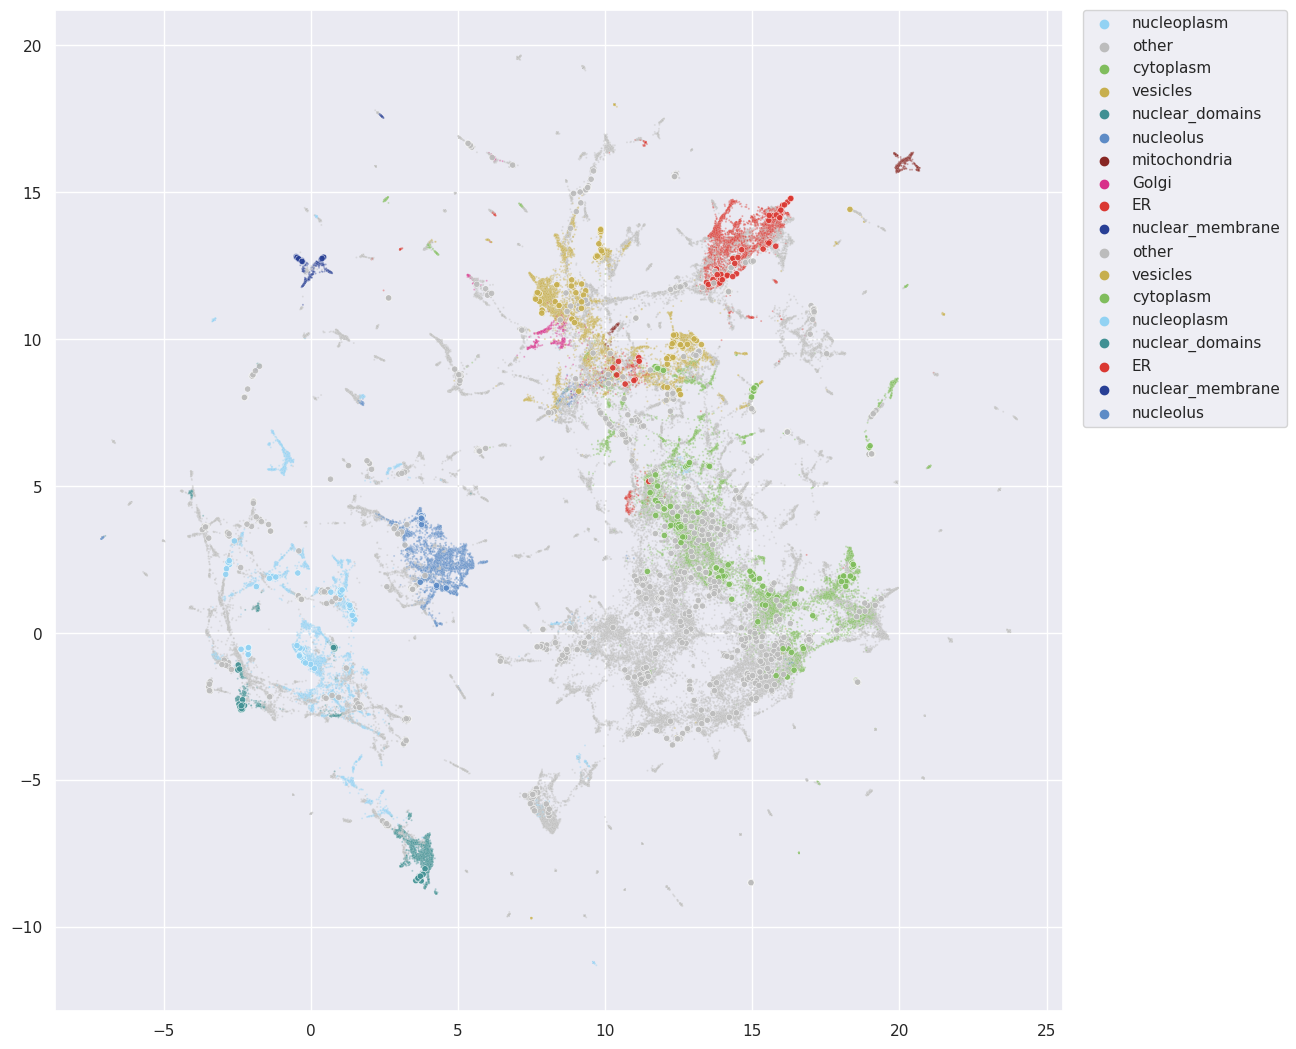

In [998]:
sns.set(rc={"figure.figsize":(13, 13)})
sns.scatterplot(x=reduced_embedding[:, 0], y=reduced_embedding[:, 1], hue=localizations, s=2, alpha=0.4, palette=label_colors)
sns.scatterplot(x=reduced_input_cytoself_embeds[:, 0], y=reduced_input_cytoself_embeds[:, 1], hue=true_localizations, s=20, alpha=0.9, palette=label_colors)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0);

## FCD scores with cyostelf

In [999]:
def compute_latent_statistics(latents, classes=None, all_classes=None):
    latents = latents.reshape(latents.shape[0], -1)

    if classes is None:
        latent_mean = np.mean(latents, axis=0)
        latent_cov = np.cov(latents, rowvar=False)
    else:
        if all_classes is None:
            all_classes = np.unique(classes)

        latent_mean = np.array([np.mean(latents[classes == c], axis=0) for c in all_classes])
        latent_cov = np.array([np.cov(latents[classes == c], rowvar=False) for c in all_classes])

    return {'mean': latent_mean, 'cov': latent_cov, 'class': all_classes}

In [1000]:
from scipy.linalg import sqrtm


def frechet_distance(mu1, sigma1, mu2, sigma2):
    """
    Compute the Fréchet distance between two multivariate Gaussian distributions.
    """
    mean_diff = mu1 - mu2
    mean_diff_squared = mean_diff.dot(mean_diff)
    cov_mean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(cov_mean):
        cov_mean = cov_mean.real
    trace_term = np.trace(sigma1 + sigma2 - 2 * cov_mean)
    frechet_dist = mean_diff_squared + trace_term
    return frechet_dist

In [1001]:
all_names = np.unique(true_names)
input_cytoself_stats = compute_latent_statistics(input_cytoself_embeds, true_names, all_names)
output_cytoself_stats = compute_latent_statistics(output_cytoself_embeds, true_names, all_names)

In [1002]:
# zipped = zip(input_cytoself_stats['mean'], input_cytoself_stats['cov'], output_cytoself_stats['mean'], output_cytoself_stats['cov'])
# fcd_scores = np.array([frechet_distance(mu1, sigma1, mu2, sigma2) for mu1, sigma1, mu2, sigma2 in zipped])

In [1003]:
# print(fcd_scores.mean())
# print(fcd_scores.std())

In [1004]:
input_cytoself_stats_all = compute_latent_statistics(input_cytoself_embeds, None, None)
output_cytoself_stats_all = compute_latent_statistics(output_cytoself_embeds, None, None)

In [1005]:
mu1, sigma1 = input_cytoself_stats_all['mean'], input_cytoself_stats_all['cov']
mu2, sigma2 = output_cytoself_stats_all['mean'], output_cytoself_stats_all['cov']
fcd_score_all = frechet_distance(mu1, sigma1, mu2, sigma2)
print(fcd_score_all)

61.45353381422837


## Medians

In [1006]:
import numpy as np
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

# Generate sample data
n = input_cytoself_stats['mean'].shape[0]
Set_A = input_cytoself_stats['mean'].copy()
Set_B = output_cytoself_stats['mean'].copy()

# Compute pairwise distances for given pairs
given_pair_dists = np.array([euclidean(Set_A[i], Set_B[i]) for i in range(n)])

# Compute pairwise distances for random pairs (1000 times)
random_pair_dists = []
np.random.seed(0)
for _ in range(1000):
    np.random.shuffle(Set_B)
    random_pair_dists.extend([euclidean(Set_A[i], Set_B[i]) for i in range(n)])

# Statistical comparison
_, p_value = mannwhitneyu(given_pair_dists, random_pair_dists)
print(f"P-value: {p_value}")

P-value: 1.6785160024176353e-17


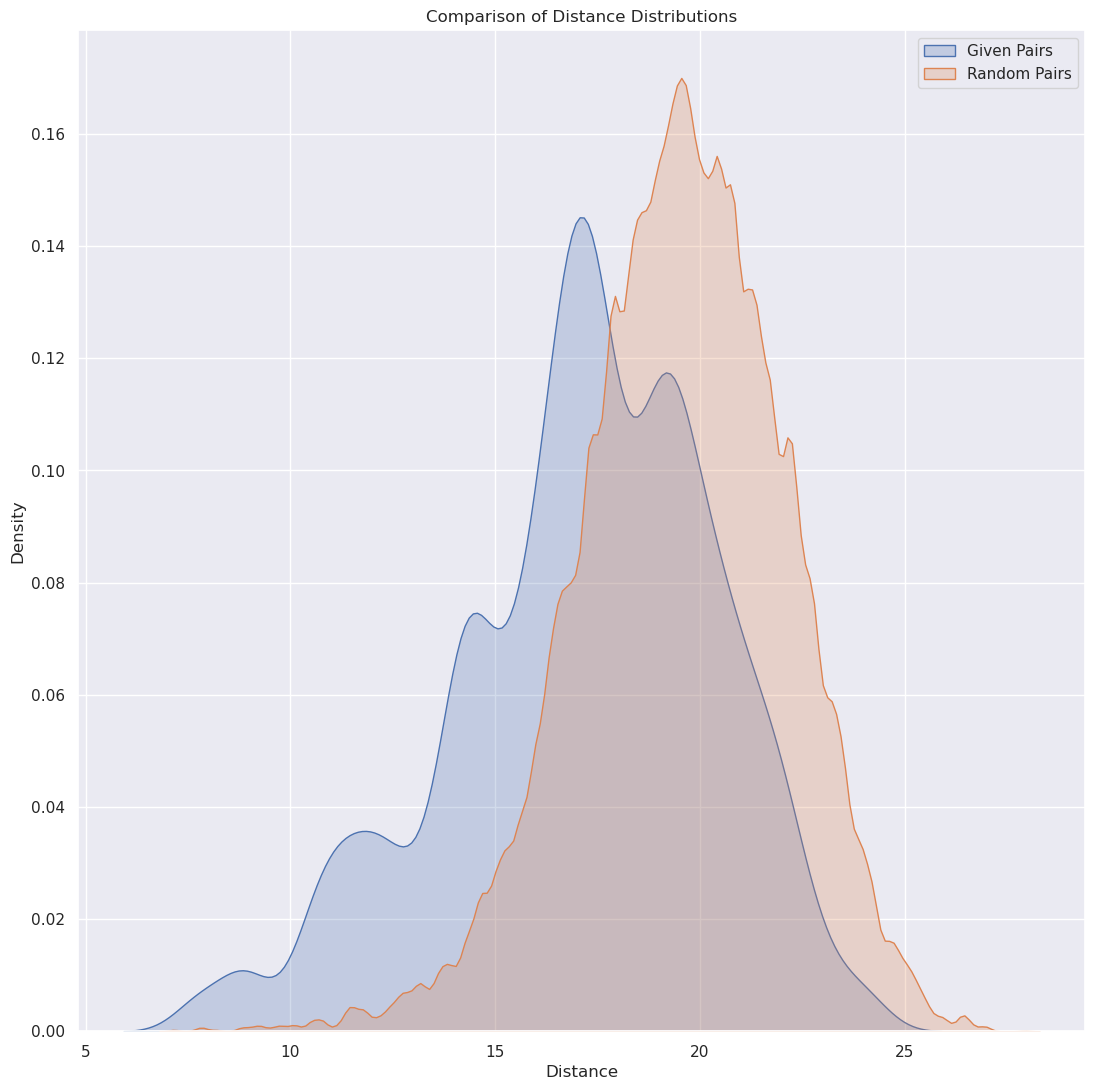

In [1007]:
# Visualization
sns.kdeplot(given_pair_dists, label="Given Pairs", shade=True, clip=(0, None), bw_adjust=0.5)
sns.kdeplot(random_pair_dists, label="Random Pairs", shade=True, clip=(0, None), bw_adjust=0.5)
plt.legend()
plt.xlabel("Distance")
plt.ylabel("Density")
plt.title("Comparison of Distance Distributions")
plt.show()

In [1008]:
print(np.mean(given_pair_dists))
print(np.mean(random_pair_dists))

17.14739800591505
19.525391441126818


In [1009]:
thresh = 16
print(all_names[given_pair_dists < thresh])

['AKAP13' 'ANAPC11' 'ARFGAP2' 'ARHGAP35' 'ARID1A' 'BAZ1A' 'BET1L' 'CALM2'
 'CAMK1' 'CASP2' 'CD9' 'CDS1' 'CERS5' 'DDOST' 'DDX47' 'ECT2' 'FASN' 'FXR1'
 'HEATR3' 'IGF2BP1' 'KIFC1' 'LAMP2' 'MDH1' 'MYL6' 'OST4' 'PHLDB1' 'PIK3C3'
 'PSMA5' 'PSMB1' 'RAB5B' 'RABGGTA' 'RANBP9' 'RPL13' 'SLC27A4' 'SLC4A2'
 'SLC5A6' 'TDP1' 'TUBA1B' 'VAPB' 'WDR46' 'YKT6' 'ZNF598']


## Run localization classifier

In [1093]:
from joblib import load

# Load the model from the file
clf = load(join(datapath, f'cytoself_{protein_split}localization_classifier.joblib'))

In [1094]:
other = true_localizations == 'other'
X_test = input_cytoself_embeds[~other]
X_test = X_test.reshape((X_test.shape[0], -1))
y_test = true_localizations[~other]

In [1095]:
y_predict = clf.predict(X_test)

In [1096]:
y_predict_scores = clf.predict_proba(X_test)

In [1098]:
y_test_indices = np.searchsorted(clf.classes_, y_test)
true_labels_for_loc = true_labels[~other]
input_localization_classification_scores = [top_k_accuracy(y_test_indices, y_predict_scores, k=k) for k in range(1, num_avg)]
input_localization_class_scores_avg = [average_logits_prediction(true_labels_for_loc, y_test_indices, y_predict_scores, M=k) for k in range(1, num_avg)]

In [1099]:
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd

class_labels = np.unique(y_test)

acc = accuracy_score(y_test, y_predict)
print(f'Accuracy {acc}')

cm = confusion_matrix(y_test, y_predict, labels=class_labels)
cm_norm = cm / cm.sum(axis=1)[:, None]
cm_df = pd.DataFrame(cm_norm, index=class_labels, columns=class_labels)


Accuracy 0.9529702970297029


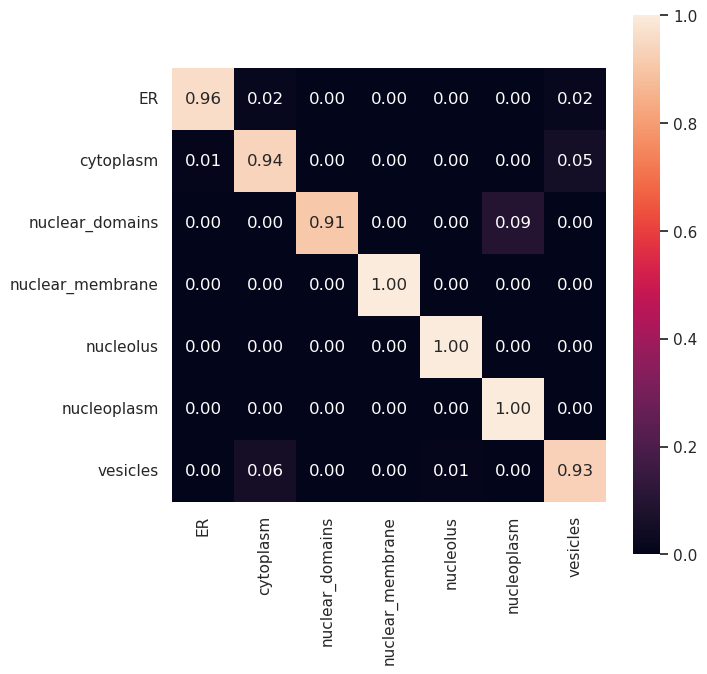

In [1100]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))
sns.heatmap(cm_df, square=True, annot=True, fmt=".2f");


In [1101]:
other = true_localizations == 'other'
X_test = output_cytoself_embeds[~other]
X_test = X_test.reshape((X_test.shape[0], -1))
y_test = true_localizations[~other]

In [1102]:
y_predict = clf.predict(X_test)

In [1103]:
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd

class_labels = np.unique(y_test)

acc = accuracy_score(y_test, y_predict)
print(f'Accuracy {acc}')

cm = confusion_matrix(y_test, y_predict, labels=class_labels)
cm_norm = cm / cm.sum(axis=1)[:, None]
cm_df = pd.DataFrame(cm_norm, index=class_labels, columns=class_labels)


Accuracy 0.7301980198019802


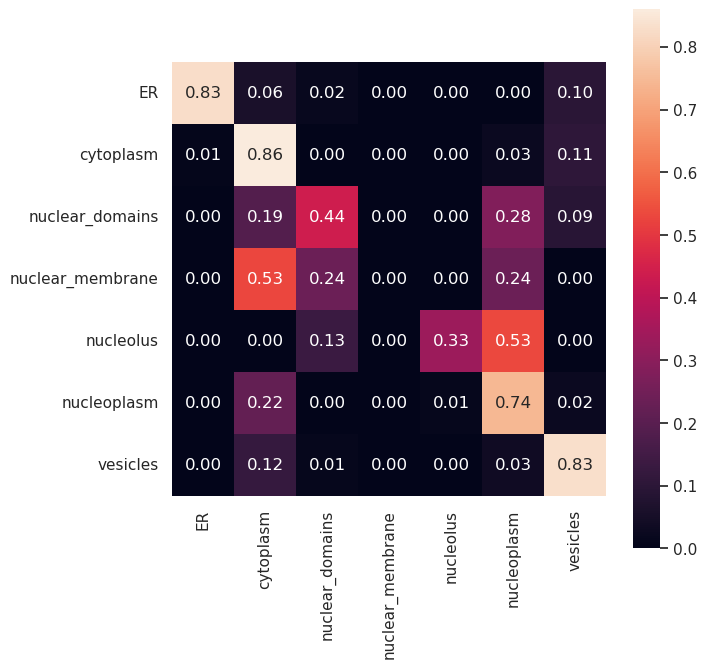

In [1104]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))
sns.heatmap(cm_df, square=True, annot=True, fmt=".2f");


In [1105]:
y_predict_scores = clf.predict_proba(X_test)

In [1106]:
true_labels_for_loc = true_labels[~other]
output_localization_classification_scores = [top_k_accuracy(y_test_indices, y_predict_scores, k=k) for k in range(1, num_avg)]
output_localization_class_scores_avg = [average_logits_prediction(true_labels_for_loc, y_test_indices, y_predict_scores, M=k) for k in range(1, num_avg)]

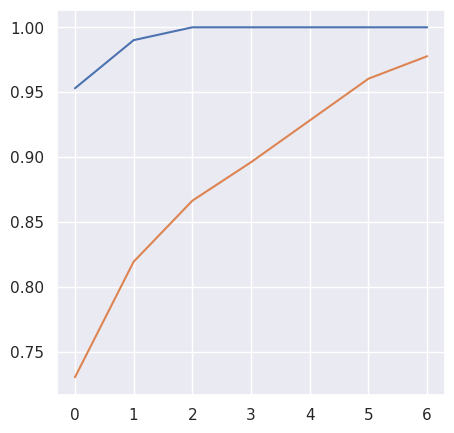

In [1107]:
plt.figure(figsize=(5, 5))
plt.plot(input_localization_classification_scores);
plt.plot(output_localization_classification_scores);

In [1108]:
print(input_localization_classification_scores[0])
print(output_localization_classification_scores[0])

print(input_localization_classification_scores[2])
print(output_localization_classification_scores[2])

0.9529702970297029
0.7301980198019802
1.0
0.8663366336633663


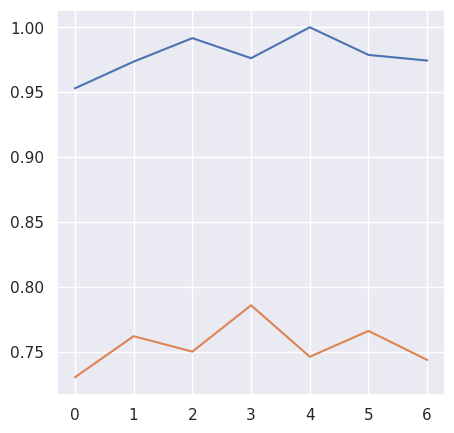

In [1109]:
plt.figure(figsize=(5, 5))
plt.plot(input_localization_class_scores_avg);
plt.plot(output_localization_class_scores_avg);

In [1110]:
print(input_localization_class_scores_avg[-1])
print(output_localization_class_scores_avg[-1])

0.9743589743589743
0.7435897435897436


## Autoencoder

In [1028]:
import umap


n_neighbors = 15
min_dist = 0.1
metric = 'euclidean'
reducer_autoencoder = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, metric=metric)
reducer_autoencoder.fit(input_autoencoder_embeds.reshape(input_autoencoder_embeds.shape[0], -1))

UMAP(tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [1029]:
from joblib import dump
from joblib import load

dump(reducer_autoencoder, join(datapath,'autoencoder_umap_model.joblib'))

# reducer = load(join(datapath,'autoencoder_umap_model.joblib'))

['/home/ec2-user/cytoself-data/results/autoencoder_umap_model.joblib']

In [1030]:
reduced_autoencoder_latent = reducer_autoencoder.transform(input_autoencoder_embeds.reshape(input_autoencoder_embeds.shape[0], -1))

In [1031]:
import seaborn as sns
import matplotlib.pyplot as plt

In [1032]:
label_colors = {
    'other': [188, 188, 188],
    'mitochondria':  [135, 38, 35],
    'nucleoplasm':  [146, 210, 243],
    'ER':  [218, 56, 50],
    'cytoplasm':  [128, 189, 93],
    'vesicles':  [199, 175, 78],
    'nuclear_membrane':  [40, 63, 149],
    'nucleolus':  [93, 139, 198],
    'Golgi':  [216, 46, 138],
    'nuclear_domains':  [64, 144, 147],
}
for key, values in label_colors.items():
    label_colors[key] = np.array(values) / 255

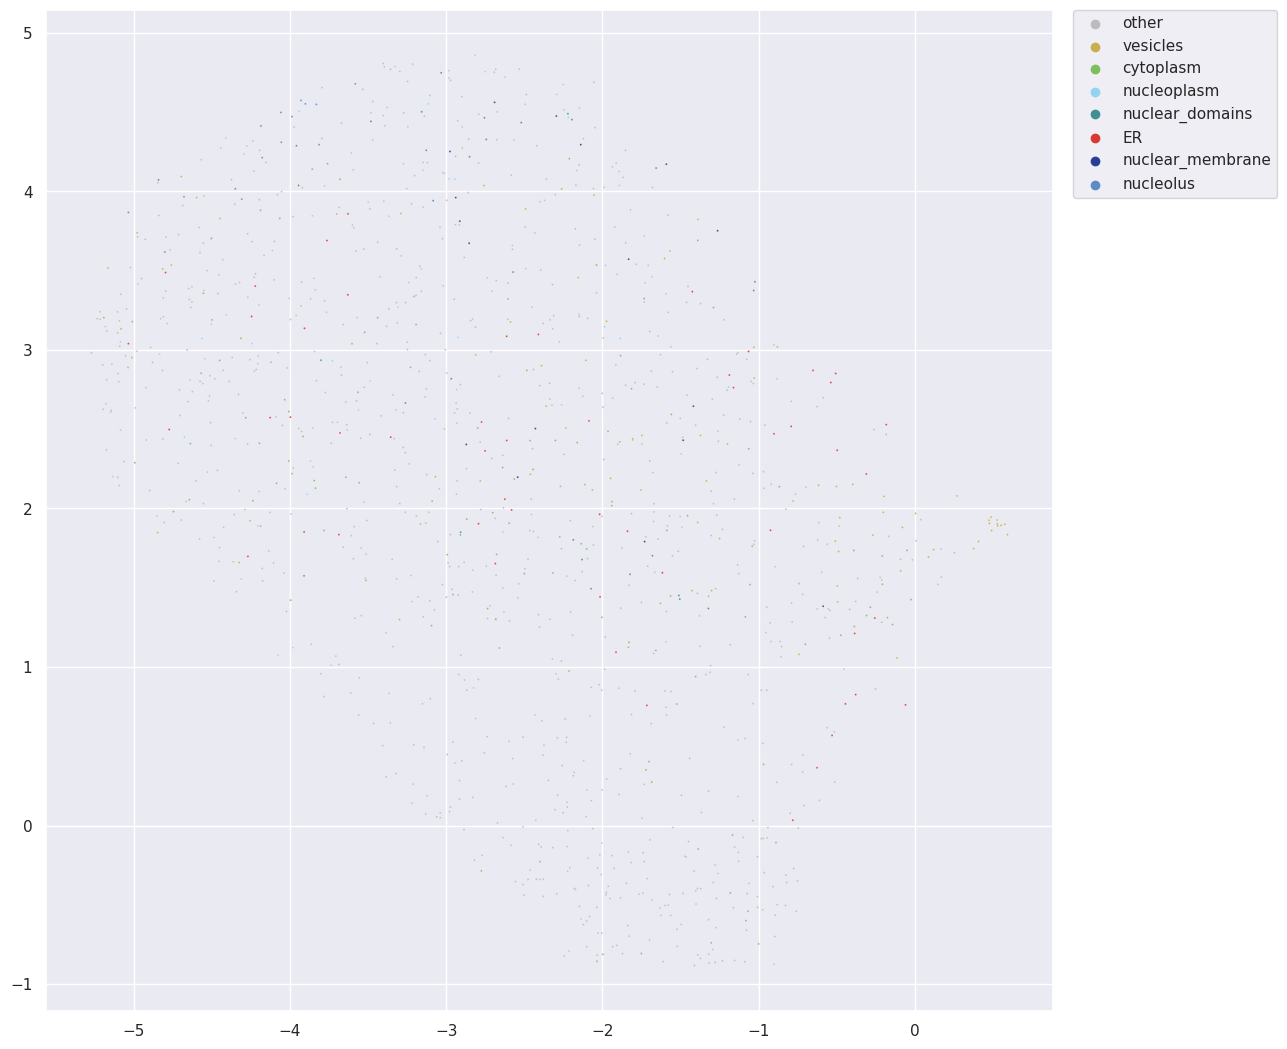

In [1033]:
sns.set(rc={"figure.figsize":(13, 13)})
sns.scatterplot(x=reduced_autoencoder_latent[:, 0], y=reduced_autoencoder_latent[:, 1], hue=true_localizations, s=2, alpha=0.9, palette=label_colors)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0);